## Metric: post-correction off-ice errors

This method assumes that the off-ice area in the source images has zero horizontal motion. So the ground truth is $V = V_x = V_y = 0$ at the off-ice area. We calculate the difference between the feature tracking results and the ground truth (i.e. zero). 

### Requirements and Limits

- There should be off-ice area in the source images. Works for mountain glaciers and outlet glaciers, but for ice sheet feature tracking it may be hard or impossible to find such the area. 
- Even though there are off-ice areas, this method may still fail if the FT algorithm cannot find cross-correlation over them. One of the possible reasons is the scene pair comes from the melting season as the surface melt changes the surface texture a lot. There are ways to check this up in this Notebook.

### Procedure

1. Prepare the feature tracking results as Geotiff files, ideally $V_x$ as one file and $V_y$ as the other. (We also show the case if only $V$ is available.) The unit for pixel value is flexible, from pixels, pixels/day, pixels/year, to meters, meters/day, to meters/year.

2. Locate off-ice area and make an ESRI shapefile (polygon format) indicating the area.

3. Use `gftt.off_ice_errors` to calculate and analyze the off-ice errors. See this notebook for details.

### Analysis

#### 1. Information and map area

- Test area: Kaskawulsh
- Test package: CARST and GIV
- Test pair: 20180304-20180405

In [1]:
# Developer's setting
%load_ext autoreload
%autoreload 2

In [2]:
import gftt
import matplotlib.pyplot as plt
from matplotlib import colors, cm
from matplotlib.colors import ListedColormap
import rasterio
from rasterio.plot import show
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.patches as patches

#### 2. Load the manifest csv as Pandas dataframe and off-ice area info

In [3]:
df = pd.read_csv('../manifest_agu21.csv', dtype=str)
df

Date Chip (px) Resolution (px) Prefilter  \
0    Sen2-20180304-20180314        48              12       Gau   
1    Sen2-20180304-20180314        48              12      NAOF   
2    Sen2-20180304-20180314        48              12      None   
3    Sen2-20180304-20180314        48               1       Gau   
4    Sen2-20180304-20180314        48               1      NAOF   
..                      ...       ...             ...       ...   
167  Sen2-20180508-20180627        64               8       Gau   
168  Sen2-20180508-20180627        32               4      NAOF   
169  Sen2-20180508-20180627        32               8      NAOF   
170  Sen2-20180508-20180627        64               4      NAOF   
171  Sen2-20180508-20180627        64               8      NAOF   

                 Subpixel  Software  \
0    16-node oversampling     CARST   
1    16-node oversampling     CARST   
2    16-node oversampling     CARST   
3    16-node oversampling     CARST   
4    16-node oversampling     CARST   
..                    ...       ...   
167                 pyrUP  autoRIFT   
168                 pyrUP  autoRIFT   
169                 pyrUP  autoRIFT   
170                 pyrUP  autoRIFT   
171                 pyrUP  autoRIFT   

                                                    Vx  \
0    /home/jovyan/Projects/PX_comparison/PX/CARST/2...   
1    /home/jovyan/Projects/PX_comparison/PX/CARST/2...   
2    /home/jovyan/Projects/PX_comparison/PX/CARST/2...   
3    /home/jovyan/Projects/PX_comparison/PX/CARST/2...   
4    /home/jovyan/Projects/PX_comparison/PX/CARST/2...   
..                                                 ...   
167  /home/jovyan/Projects/PX_comparison/PX/autoRIF...   
168  /home/jovyan/Projects/PX_comparison/PX/autoRIF...   
169  /home/jovyan/Projects/PX_comparison/PX/autoRIF...   
170  /home/jovyan/Projects/PX_comparison/PX/autoRIF...   
171  /home/jovyan/Projects/PX_comparison/PX/autoRIF...   

                                                    Vy  
0    /home/jovyan/Projects/PX_comparison/PX/CARST/2...  
1    /home/jovyan/Projects/PX_comparison/PX/CARST/2...  
2    /home/jovyan/Projects/PX_comparison/PX/CARST/2...  
3    /home/jovyan/Projects/PX_comparison/PX/CARST/2...  
4    /home/jovyan/Projects/PX_comparison/PX/CARST/2...  
..                                                 ...  
167  /home/jovyan/Projects/PX_comparison/PX/autoRIF...  
168  /home/jovyan/Projects/PX_comparison/PX/autoRIF...  
169  /home/jovyan/Projects/PX_comparison/PX/autoRIF...  
170  /home/jovyan/Projects/PX_comparison/PX/autoRIF...  
171  /home/jovyan/Projects/PX_comparison/PX/autoRIF...  

[172 rows x 8 columns]

In [4]:
# off-ice area
in_shp = '../../data/shapefiles/bedrock_V1.shp'
off_ice = gpd.read_file(in_shp)
in_shp2 = '/home/jovyan/Projects/PX_comparison/Bedrock_shp/Kaskawulsh_RGI60_EPSG32607.shp'
off_ice2 = gpd.read_file(in_shp2)

#### 3. Single-pair demo 

In [5]:
## Example results
demo = df.loc[30]
print(demo)

Date                                           LS8-20180304-20180405
Chip (px)                                                         64
Resolution (px)                                                    4
Prefilter                                                        Gau
Subpixel                                        16-node oversampling
Software                                                       CARST
Vx                 /home/jovyan/Projects/PX_comparison/PX/CARST/2...
Vy                 /home/jovyan/Projects/PX_comparison/PX/CARST/2...
Name: 30, dtype: object


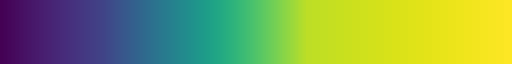

In [6]:
viridis = cm.get_cmap('viridis', 256)
newcolors1 = viridis(np.linspace(0, 0.2, 128))
newcolors2 = viridis(np.linspace(0.2, 0.9, 256))
newcolors3 = viridis(np.linspace(0.9, 1, 256))
newcolors = np.vstack((newcolors1, newcolors2, newcolors3))
cmap = ListedColormap(newcolors)
cmap.set_over(np.array([202,0,32,128]) / 255)
cmap.set_under(np.array([0,0,0,128]) / 255)
cmap

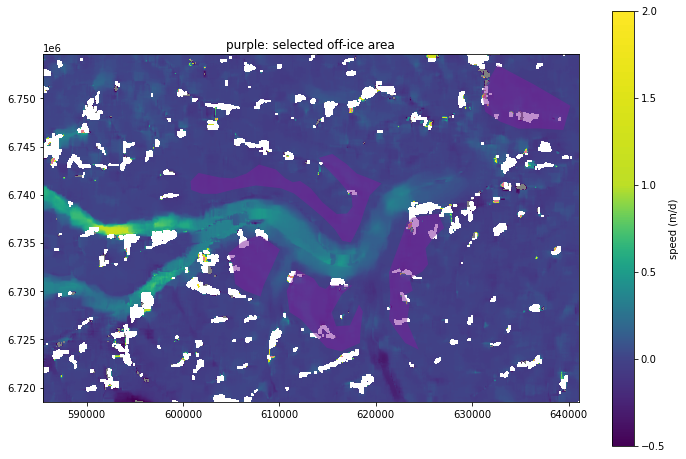

In [7]:
fig, ax0 = plt.subplots(1, 1, figsize=(12, 8))

# with rasterio.open(demo.Vx.replace('vx', 'mag')) as v_src:
#     v = v_src.read(1)
#     show(v_src, ax=ax0, vmin=0, vmax=2, cmap=cmap)

with rasterio.open(demo.Vx) as v_src:
    v = v_src.read(1)
    show(v_src, ax=ax0, vmin=-0.5, vmax=2, cmap=cmap)
    
cbar =  fig.colorbar(cm.ScalarMappable(norm=colors.Normalize(vmin=-0.5, vmax=2), cmap=cmap), ax=ax0)
cbar.set_label('speed (m/d)')
off_ice.plot(ax=ax0, alpha=0.5, facecolor='xkcd:purple')
ax0.set_title('purple: selected off-ice area');

The GFTT module has a fuction called `off_ice_errors` for this metric:

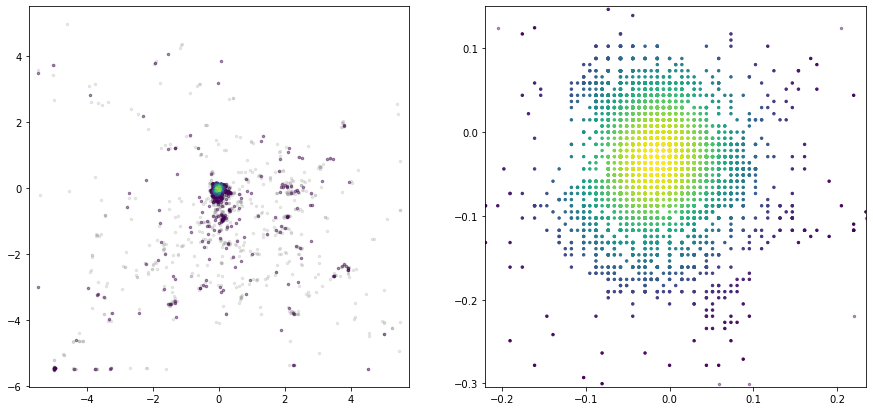

In [8]:
fig, ax1 = plt.subplots(1, 2, figsize=(15, 7))

for ax in ax1:
    ax.axis('equal')
vx, vy, z, thres_idx = gftt.off_ice_errors(vxfile=demo.Vx, vyfile=demo.Vy, off_ice_area=in_shp, ax=ax1[0])
gftt.plot_off_ice_errors(vx, vy, z, thres_idx, ax=ax1[1])


In [9]:
tmp = gftt.mask_by_shp(off_ice['geometry'], v, rasterio.open(demo.Vx))

In this case, x-axis is $V_x$ (m/day), y-axis is $V_y$ (m/day), color represents the Gaussian kernel density estimate, and transparent points indicate that those points have a kernel density below a chosen confidence level. The default `thres_sigma` parameter is 3.0, corresponding to a confidence level of 99.7%. 

To estimate whether these errors are randomly distributed, we can see how close this distribution is to the Gaussian distribution. One criterion is to see how much the non-transparent points account for 99.7% of all the points and whether that is close to 99.7%:

In [10]:
np.sum(thres_idx) / vx.shape

array([0.9746])

This gives us 94.5%, indicating more points falling outside of the chosen confidence interval than assumed. This is okay because the standard deviation of these points would be a conservative estimate, affected by many outliers and larger than the actual standard deviation. 

The standard deviation of $V_x$ and $V_y$ can be thus assigned as the overall uncertainty of both on-ice and off-ice pixels, which serves as a metric for estimating the feature tracking results. 

In [11]:
print('Vx std: {:5f}  m/day'.format(np.std(vx, ddof=1)))
print('Vy std: {:5f}  m/day'.format(np.std(vy, ddof=1)))

Vx std: 0.336275  m/day
Vy std: 0.354937  m/day


Or roughly 1/5 of the pixel size since this is a 32-day pair.

<!-- ![CARST-bedrock](./20180304-20180405_bedrock_vx-vs-vy.png) -->

In [12]:
print('Vx std: {:5f}  m/day'.format(np.std(vx[thres_idx], ddof=1)))
print('Vy std: {:5f}  m/day'.format(np.std(vy[thres_idx], ddof=1)))

Vx std: 0.041010  m/day
Vy std: 0.052311  m/day


#### 3.1 image with many off-ice pixels

In [13]:
# CARST files (Vx and Vy)
carst_geotiff_x = '/home/jovyan/Projects/PX_comparison/PX/CARST/20180304_20180405_LS8-061018_chip32_skip1_Gau/20180304-20180405_velo-raw_vx.tif'
carst_geotiff_y = '/home/jovyan/Projects/PX_comparison/PX/CARST/20180304_20180405_LS8-061018_chip32_skip1_Gau/20180304-20180405_velo-raw_vy.tif'

**old code (using all 721549 samples)**

This would take 2 hours to run. Not very effective because for many areas the KDE is just very low.

In [14]:
# %%time
# vx, vy, z, thres_idx = gftt.off_ice_errors(vxfile=carst_geotiff_x, vyfile=carst_geotiff_y, off_ice_area=in_shp)
# max_n = 721549

In [15]:
#### These numbers are very similar from only using n=10000 points.
# print(np.sum(thres_idx) / vx.shape)
# print('Vx std: {:5f}  m/day'.format(np.std(vx, ddof=1)))
# print('Vy std: {:5f}  m/day'.format(np.std(vy, ddof=1)))

**New code (using 10000 samples)**

CPU times: user 1.6 s, sys: 58 ms, total: 1.65 s
Wall time: 1.69 s


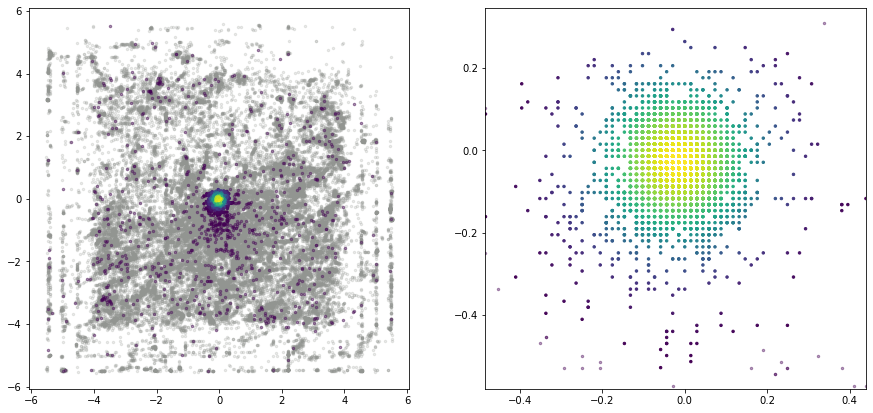

In [16]:
%%time
fig, ax2 = plt.subplots(1, 2, figsize=(15, 7))

for ax in ax2:
    ax.axis('equal')
vx, vy, z, thres_idx = gftt.off_ice_errors(vxfile=carst_geotiff_x, vyfile=carst_geotiff_y, off_ice_area=in_shp, max_n=10000, ax=ax2[0])
gftt.plot_off_ice_errors(vx, vy, z, thres_idx, ax=ax2[1])

In [17]:
print(np.sum(thres_idx) / vx.shape)
print('Vx std: {:5f}  m/day'.format(np.std(vx, ddof=1)))
print('Vy std: {:5f}  m/day'.format(np.std(vy, ddof=1)))

[0.9106]
Vx std: 0.683982  m/day
Vy std: 0.675714  m/day


In [18]:
print('Vx std: {:5f}  m/day'.format(np.std(vx[thres_idx], ddof=1)))
print('Vy std: {:5f}  m/day'.format(np.std(vy[thres_idx], ddof=1)))

Vx std: 0.063575  m/day
Vy std: 0.072160  m/day


#### 4. Many tests

In [19]:
## Example results

# demo = df.loc[df['Date'] == 'LS8-20180304-20180405']
demo = df.loc[np.logical_and(df['Date'] == 'LS8-20180304-20180405', df['Subpixel'] != 'affine')]
# demo = df.loc[df['Date'] == 'LS8-20180802-20180818']
# demo = df.loc[np.logical_and(df['Date'] == 'LS8-20180802-20180818', df['Subpixel'] != 'affine')]
# demo = df.loc[df['Date'] == 'Sen2-20180304-20180314']
# demo = df.loc[np.logical_and(df['Date'] == 'Sen2-20180304-20180314', df['Subpixel'] != 'affine')]
# demo = df.loc[df['Date'] == 'Sen2-20180508-20180627']
# demo = df.loc[np.logical_and(df['Date'] == 'Sen2-20180508-20180627', df['Subpixel'] != 'affine')]
# There are 43-1 tests
demo

Date Chip (px) Resolution (px) Prefilter  \
18   LS8-20180304-20180405        32               1       Gau   
19   LS8-20180304-20180405        32               1      NAOF   
20   LS8-20180304-20180405        32               1      None   
21   LS8-20180304-20180405        32               4       Gau   
22   LS8-20180304-20180405        32               4      NAOF   
23   LS8-20180304-20180405        32               4      None   
24   LS8-20180304-20180405        32               8       Gau   
25   LS8-20180304-20180405        32               8      NAOF   
26   LS8-20180304-20180405        32               8      None   
27   LS8-20180304-20180405        64               1       Gau   
28   LS8-20180304-20180405        64               1      NAOF   
29   LS8-20180304-20180405        64               1      None   
30   LS8-20180304-20180405        64               4       Gau   
31   LS8-20180304-20180405        64               4      NAOF   
32   LS8-20180304-20180405        64               4      None   
33   LS8-20180304-20180405        64               8       Gau   
34   LS8-20180304-20180405        64               8      NAOF   
35   LS8-20180304-20180405        64               8      None   
72   LS8-20180304-20180405     multi              16      NAOF   
73   LS8-20180304-20180405     multi               4      NAOF   
74   LS8-20180304-20180405     multi              16       Gau   
75   LS8-20180304-20180405     multi               4       Gau   
76   LS8-20180304-20180405     multi              16      None   
77   LS8-20180304-20180405     multi               4      None   
96   LS8-20180304-20180405        31               1       Gau   
97   LS8-20180304-20180405        65               1       Gau   
104  LS8-20180304-20180405        31               1      None   
105  LS8-20180304-20180405        65               1      None   
112  LS8-20180304-20180405        31               1       LoG   
113  LS8-20180304-20180405        31               1       LoG   
124  LS8-20180304-20180405        32               4      None   
125  LS8-20180304-20180405        32               8      None   
126  LS8-20180304-20180405        64               4      None   
127  LS8-20180304-20180405        64               8      None   
128  LS8-20180304-20180405        32               4       Gau   
129  LS8-20180304-20180405        32               8       Gau   
130  LS8-20180304-20180405        64               4       Gau   
131  LS8-20180304-20180405        64               8       Gau   
132  LS8-20180304-20180405        32               4      NAOF   
133  LS8-20180304-20180405        32               8      NAOF   
134  LS8-20180304-20180405        64               4      NAOF   
135  LS8-20180304-20180405        64               8      NAOF   

                  Subpixel  Software  \
18    16-node oversampling     CARST   
19    16-node oversampling     CARST   
20    16-node oversampling     CARST   
21    16-node oversampling     CARST   
22    16-node oversampling     CARST   
23    16-node oversampling     CARST   
24    16-node oversampling     CARST   
25    16-node oversampling     CARST   
26    16-node oversampling     CARST   
27    16-node oversampling     CARST   
28    16-node oversampling     CARST   
29    16-node oversampling     CARST   
30    16-node oversampling     CARST   
31    16-node oversampling     CARST   
32    16-node oversampling     CARST   
33    16-node oversampling     CARST   
34    16-node oversampling     CARST   
35    16-node oversampling     CARST   
72   interest point groups       GIV   
73   interest point groups       GIV   
74   interest point groups       GIV   
75   interest point groups       GIV   
76   interest point groups       GIV   
77   interest point groups       GIV   
96               parabolic      Vmap   
97               parabolic      Vmap   
104              parabolic      Vmap   
105              parabolic      Vmap   
112              parabo

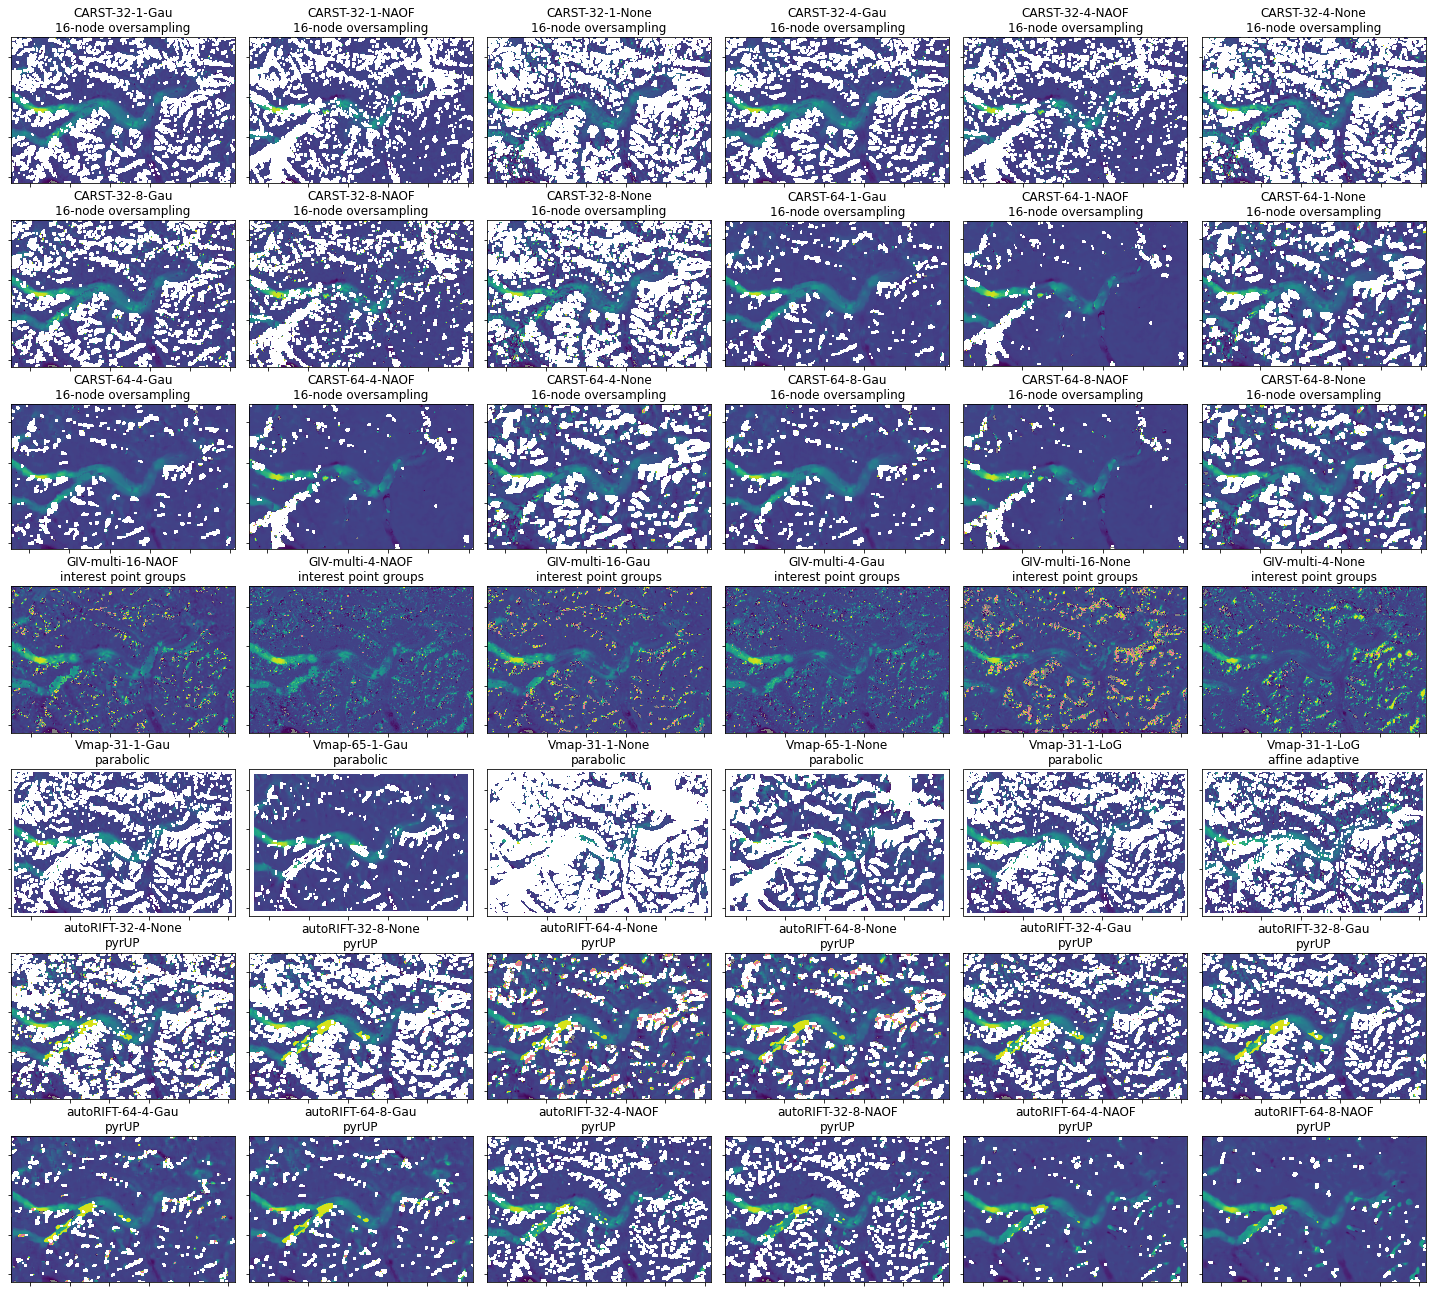

In [20]:
fig, ax3 = plt.subplots(7, 6, figsize=(20, 18))

n = 0

for idx, row in demo.iterrows():
    label = '-'.join((row.Software, row['Chip (px)'], row['Resolution (px)'], row.Prefilter)) + '\n' + row.Subpixel
    ax_sel = ax3[n // 6, n % 6]
    
    with rasterio.open(row.Vx) as vx_src:
        show(vx_src, ax=ax_sel, vmin=-0.5, vmax=2, cmap=cmap)
    ax_sel.set_title(label)
    ax_sel.xaxis.set_ticklabels([])
    ax_sel.yaxis.set_ticklabels([])
        
    n += 1
    
plt.tight_layout()
fig.patch.set_facecolor('xkcd:white')
# fig.savefig('tmp.png')

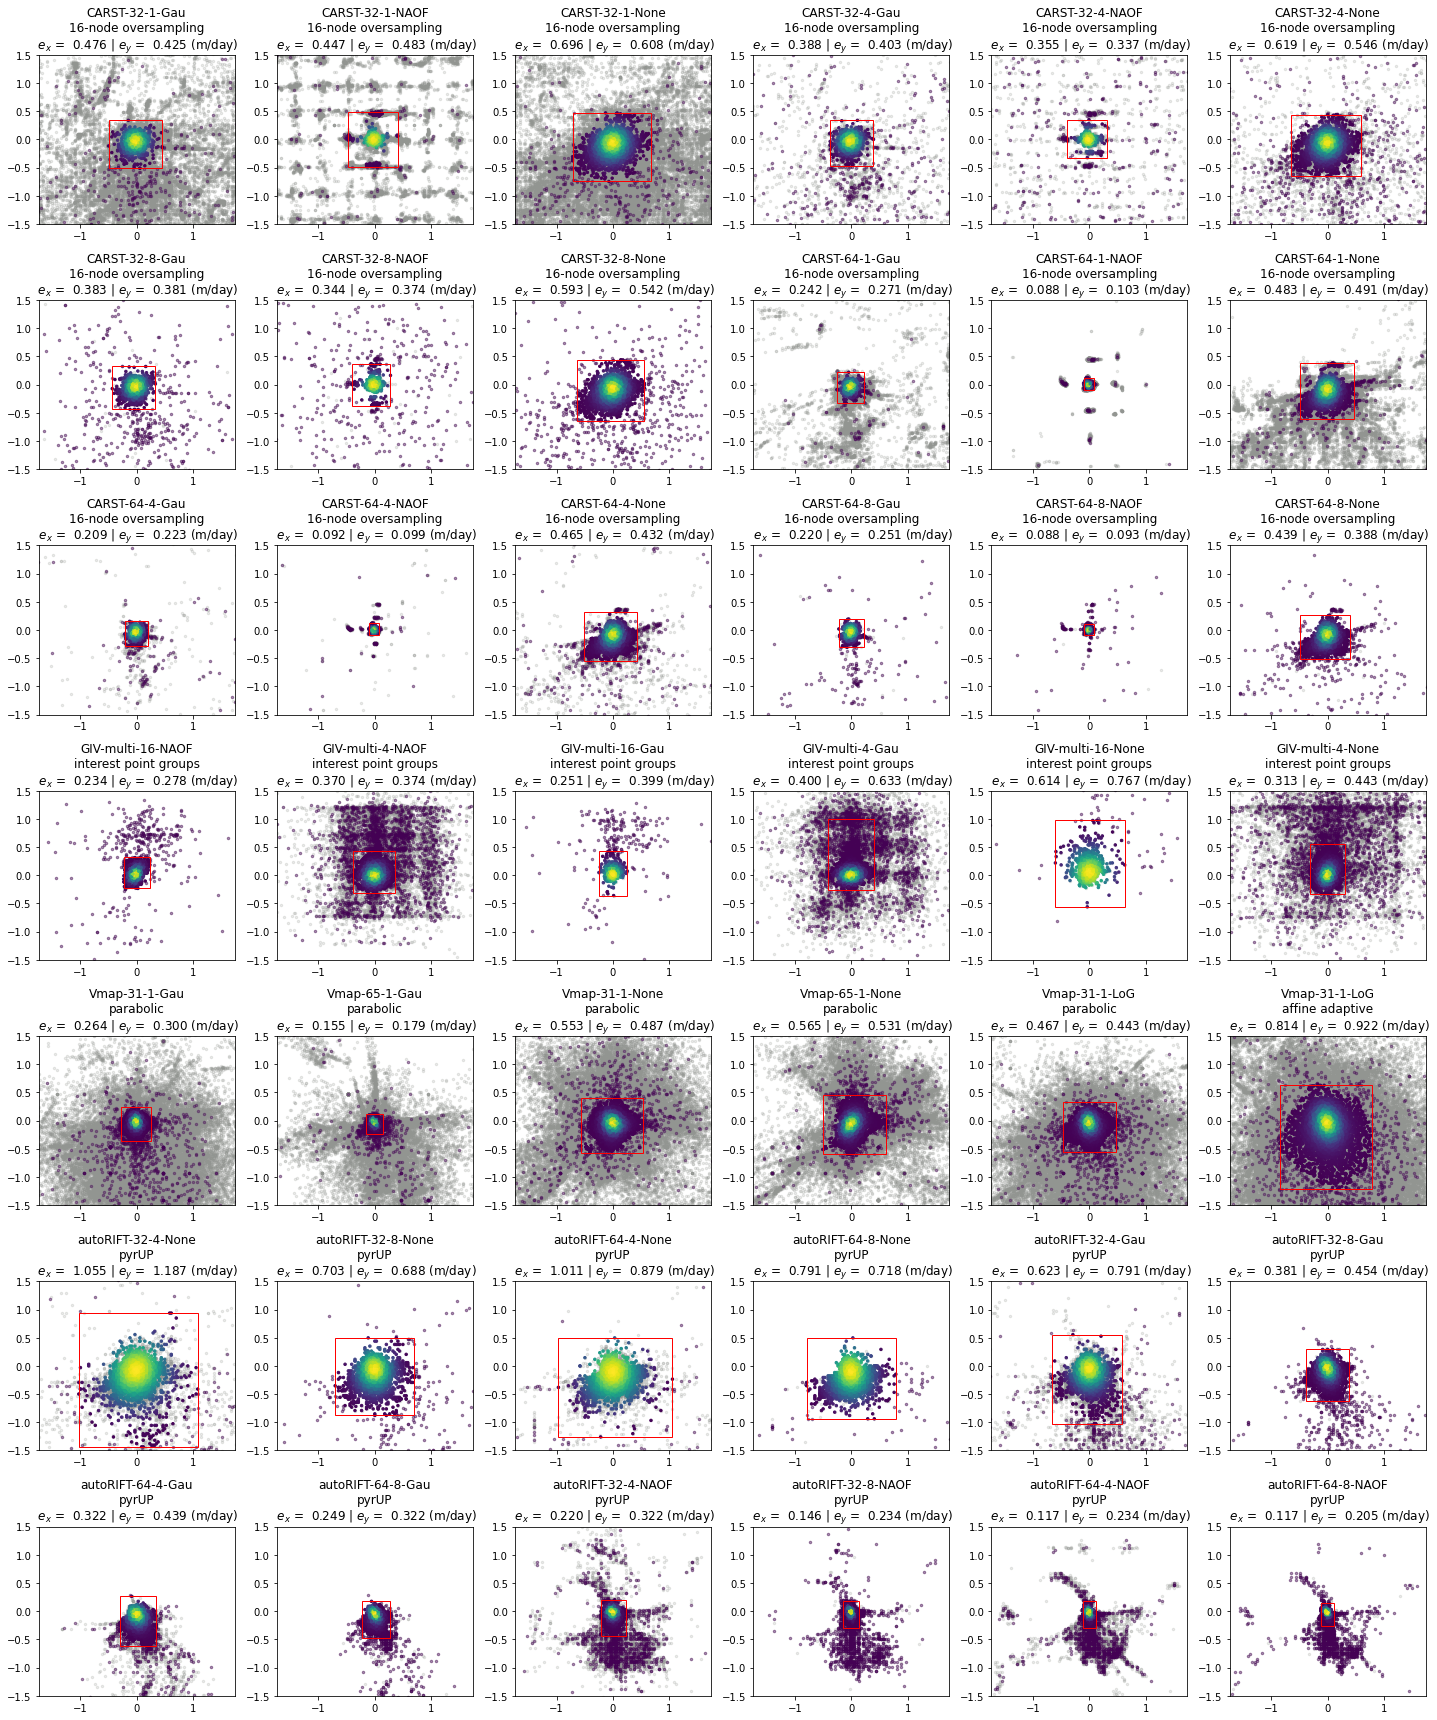

In [21]:
fig, ax4 = plt.subplots(7, 6, figsize=(20, 24))

n = 0

for idx, row in demo.iterrows():
    label = '-'.join((row.Software, row['Chip (px)'], row['Resolution (px)'], row.Prefilter)) + '\n' + row.Subpixel
    ax_sel = ax4[n // 6, n % 6]
    ax_sel.axis('equal')
    
    if row.Software == 'GIV':
        vx, vy, z, thres_idx = gftt.off_ice_errors(vxfile=row.Vx, vyfile=row.Vy, wfile=row.Vx.replace('u_', 'pkr_'), off_ice_area=in_shp, max_n=10000, plot=True, ax=ax_sel)
    else:
        vx, vy, z, thres_idx = gftt.off_ice_errors(vxfile=row.Vx, vyfile=row.Vy, off_ice_area=in_shp, max_n=10000, plot=True, ax=ax_sel)
    # gftt.plot_off_ice_errors(vx, vy, z, thres_idx, ax=ax_sel, zoom=True)
    ax_sel.set_xlim(-1.5, 1.5)
    ax_sel.set_ylim(-1.5, 1.5)

    rect = patches.Rectangle((min(vx[thres_idx]), min(vy[thres_idx])), max(vx[thres_idx]) - min(vx[thres_idx]), max(vy[thres_idx]) - min(vy[thres_idx]), 
                              linewidth=1, edgecolor='r', facecolor='none')
    ax_sel.add_patch(rect)
    label += '\n $e_x$ = {:6.3f} | $e_y$ = {:6.3f} (m/day)'.format(0.5 * (max(vx[thres_idx]) - min(vx[thres_idx])), 
                                                                   0.5 * (max(vy[thres_idx]) - min(vy[thres_idx])))
    ax_sel.set_title(label)
    # ax_sel.xaxis.set_ticklabels([])
    # ax_sel.yaxis.set_ticklabels([])
        
    n += 1
    
    
plt.tight_layout()
fig.patch.set_facecolor('xkcd:white')
fig.savefig('tmp.png')

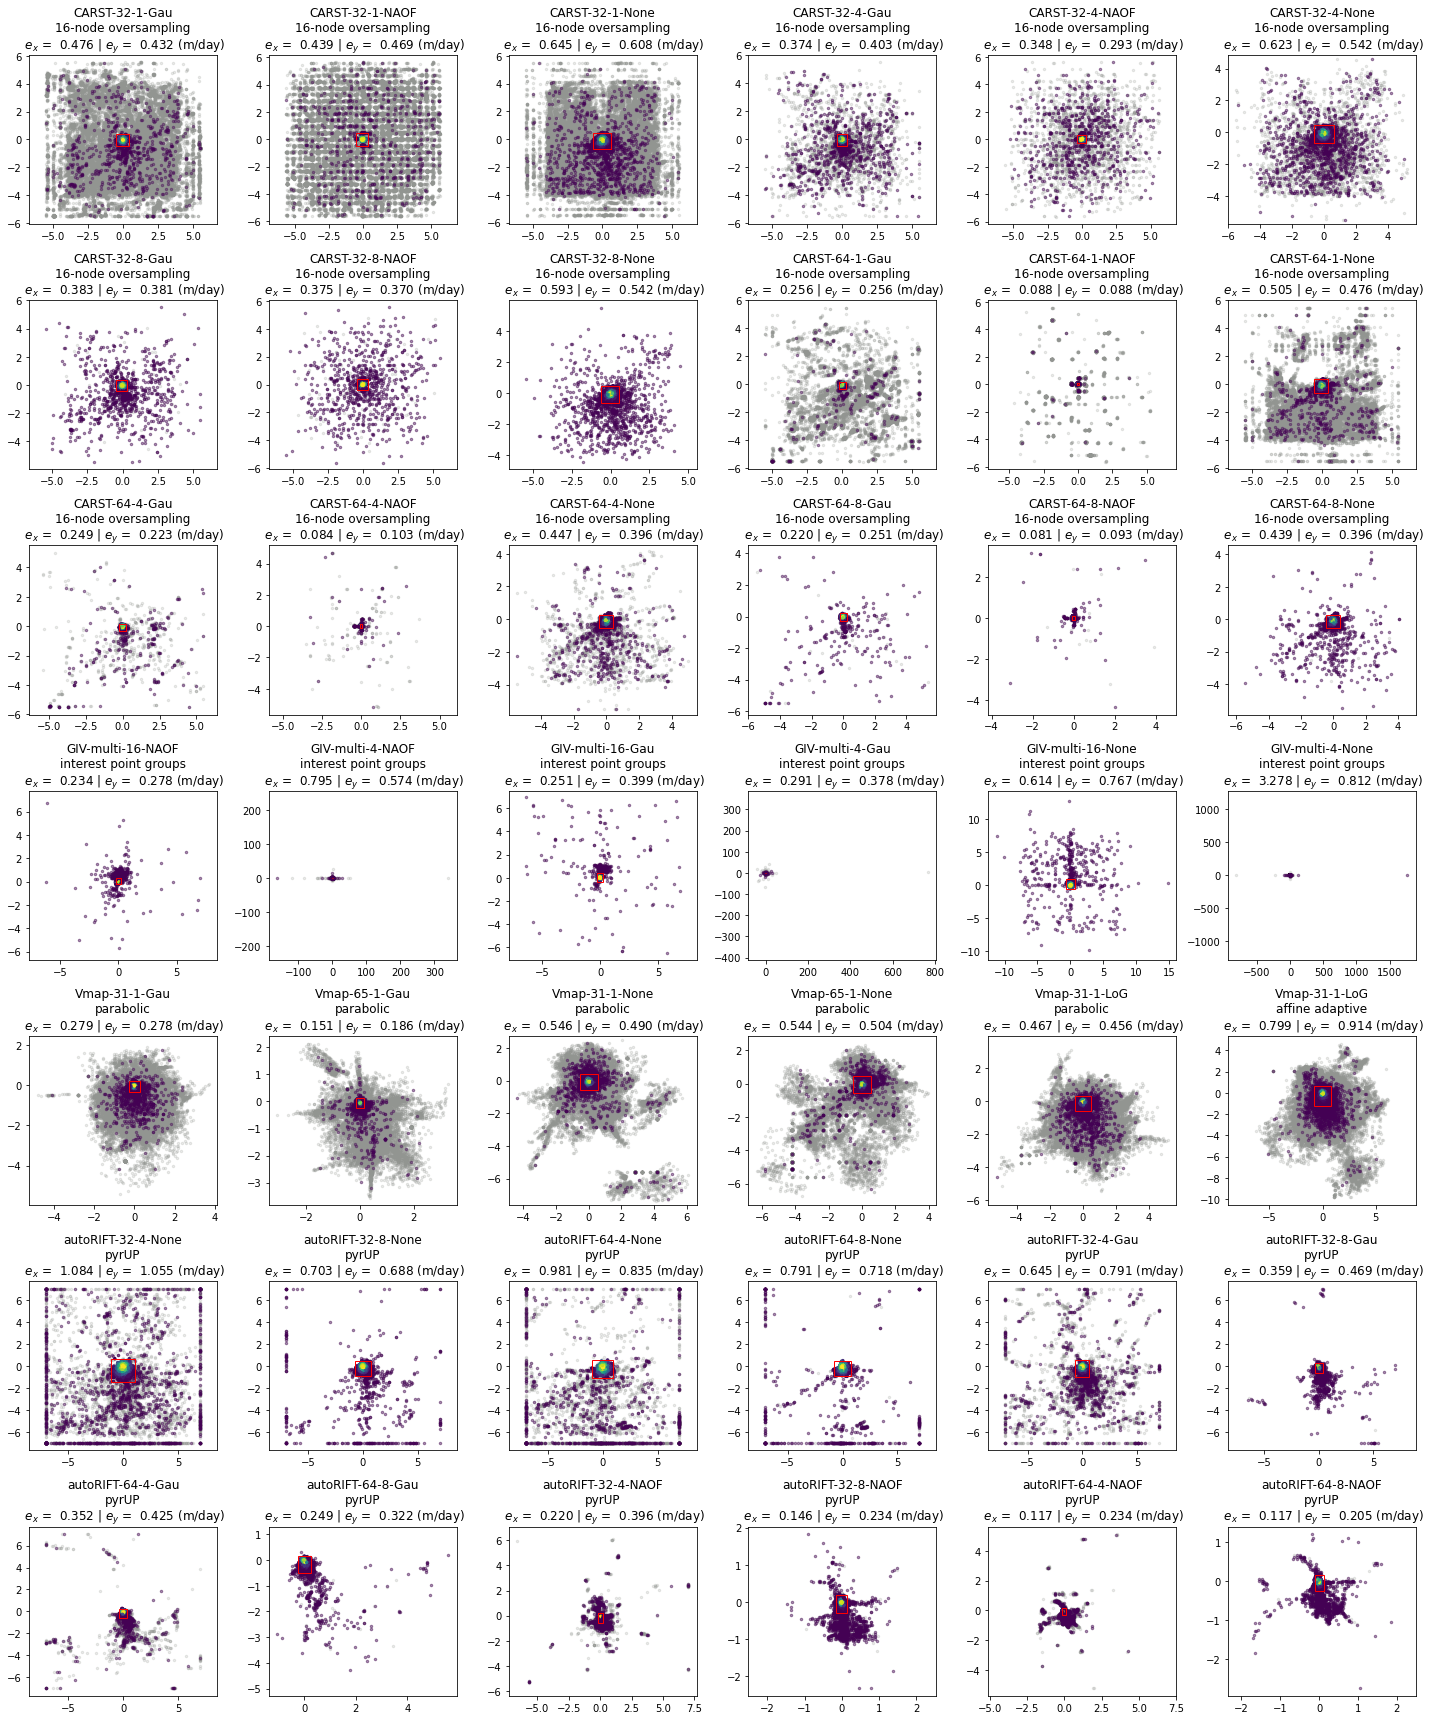

In [22]:
fig, ax5 = plt.subplots(7, 6, figsize=(20, 24))

n = 0

for idx, row in demo.iterrows():
    label = '-'.join((row.Software, row['Chip (px)'], row['Resolution (px)'], row.Prefilter)) + '\n' + row.Subpixel
    ax_sel = ax5[n // 6, n % 6]
    ax_sel.axis('equal')

    if row.Software == 'GIV':
        vx, vy, z, thres_idx = gftt.off_ice_errors(vxfile=row.Vx, vyfile=row.Vy, wfile=row.Vx.replace('u_', 'pkr_'), off_ice_area=in_shp, max_n=10000, plot=True, ax=ax_sel)
    else:
        vx, vy, z, thres_idx = gftt.off_ice_errors(vxfile=row.Vx, vyfile=row.Vy, off_ice_area=in_shp, max_n=10000, plot=True, ax=ax_sel)
    # gftt.plot_off_ice_errors(vx, vy, z, thres_idx, ax=ax_sel, zoom=True)
    # ax_sel.set_xlim(-0.5, 0.5)
    # ax_sel.set_ylim(-0.5, 0.5)
    
    rect = patches.Rectangle((min(vx[thres_idx]), min(vy[thres_idx])), max(vx[thres_idx]) - min(vx[thres_idx]), max(vy[thres_idx]) - min(vy[thres_idx]), 
                              linewidth=1, edgecolor='r', facecolor='none')
    ax_sel.add_patch(rect)
    label += '\n $e_x$ = {:6.3f} | $e_y$ = {:6.3f} (m/day)'.format(0.5 * (max(vx[thres_idx]) - min(vx[thres_idx])), 
                                                                   0.5 * (max(vy[thres_idx]) - min(vy[thres_idx])))
    ax_sel.set_title(label)
    # ax_sel.xaxis.set_ticklabels([])
    # ax_sel.yaxis.set_ticklabels([])
        
    n += 1
    
plt.tight_layout()
fig.patch.set_facecolor('xkcd:white')

In [23]:
demo = df.loc[18]
demo

Date                                           LS8-20180304-20180405
Chip (px)                                                         32
Resolution (px)                                                    1
Prefilter                                                        Gau
Subpixel                                        16-node oversampling
Software                                                       CARST
Vx                 /home/jovyan/Projects/PX_comparison/PX/CARST/2...
Vy                 /home/jovyan/Projects/PX_comparison/PX/CARST/2...
Name: 18, dtype: object

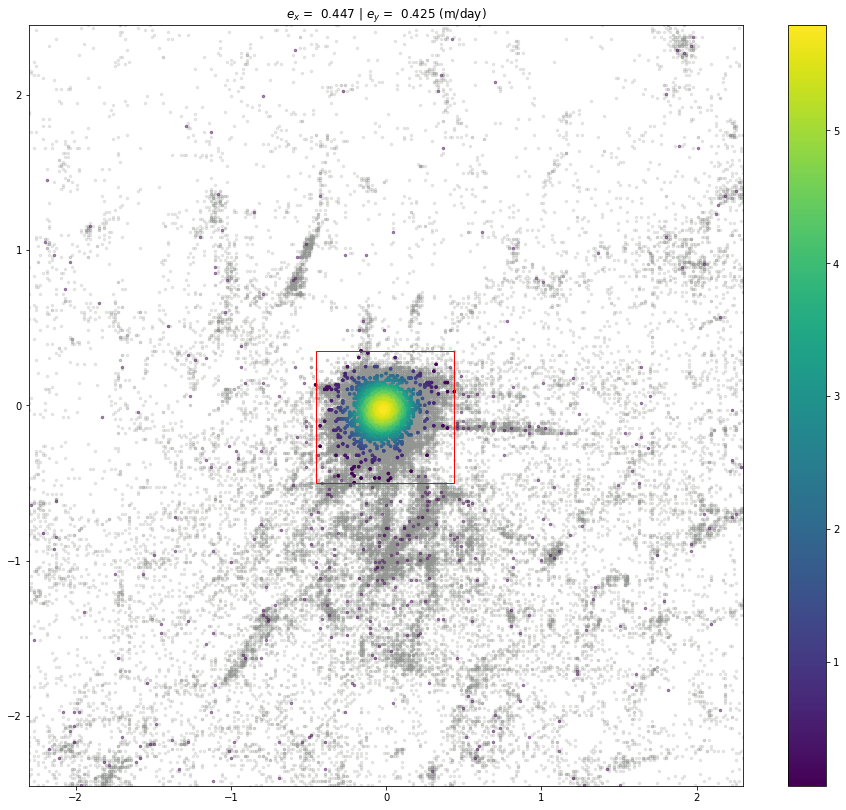

In [24]:
import matplotlib.patches as patches

viridis = cm.get_cmap('viridis', 12)
pt_style = {'s': 6, 'edgecolor': None}

fig, axt = plt.subplots(1, 1, figsize=(16, 14))
vx, vy, z, thres_idx = gftt.off_ice_errors(vxfile=demo.Vx, vyfile=demo.Vy, off_ice_area=in_shp, max_n=10000, plot=True, ax=axt)

idx = thres_idx    # alias
axt.axis('equal')
tmp = axt.scatter(vx[idx], vy[idx], c=z[idx], **pt_style)
# axt.scatter(vx[~idx], vy[~idx], color=viridis(0), alpha=0.4, **pt_style)
# # axt.set_xlim((min(vx[idx]), max(vx[idx])))
# # axt.set_ylim((min(vy[idx]), max(vy[idx])))
axt.set_xlim(-2.3, 2.3)
axt.set_ylim(-2.3, 2.3)

# (left, bottom), width, height
rect = patches.Rectangle((min(vx[thres_idx]), min(vy[thres_idx])), max(vx[thres_idx]) - min(vx[thres_idx]), max(vy[thres_idx]) - min(vy[thres_idx]), 
                         linewidth=1, edgecolor='r', facecolor='none')
axt.add_patch(rect)
axt.set_title('$e_x$ = {:6.3f} | $e_y$ = {:6.3f} (m/day)'.format(0.5 * (max(vx[thres_idx]) - min(vx[thres_idx])), 
                                                                 0.5 * (max(vy[thres_idx]) - min(vy[thres_idx]))))

fig.colorbar(tmp)

In [25]:
from scipy.stats import gaussian_kde
xy = np.vstack([vx, vy])
kernel = gaussian_kde(xy)

In [26]:
kernel.integrate_box((-2.3, -2.3), (2.3, 2.3))

0.9495827222557343

In [27]:
print('Vx std: {:5f}  m/day'.format(np.std(vx, ddof=1)))
print('Vy std: {:5f}  m/day'.format(np.std(vy, ddof=1)))

Vx std: 0.688058  m/day
Vy std: 0.670747  m/day


In [28]:
print('Vx std: {:5f}  m/day'.format(np.std(vx[thres_idx], ddof=1)))
print('Vy std: {:5f}  m/day'.format(np.std(vy[thres_idx], ddof=1)))

Vx std: 0.063097  m/day
Vy std: 0.068629  m/day


In [29]:
print('Vx thres max: {:5f} m/day'.format(np.max(vx[thres_idx])))
print('Vy thres max: {:5f} m/day'.format(np.max(vy[thres_idx])))

Vx thres max: 0.439453 m/day
Vy thres max: 0.351562 m/day


In [30]:
min(vy[thres_idx])

-0.49804688

In [31]:
max(vy[thres_idx])

0.3515625

In [32]:
np.median(vy[thres_idx])

-0.029296875

In [33]:
max(vy[thres_idx]) + min(vy[thres_idx])

-0.14648438

In [34]:
demo = df.loc[72]
demo

Date                                           LS8-20180304-20180405
Chip (px)                                                      multi
Resolution (px)                                                   16
Prefilter                                                       NAOF
Subpixel                                       interest point groups
Software                                                         GIV
Vx                 /home/jovyan/Projects/PX_comparison/PX/GIV/u_l...
Vy                 /home/jovyan/Projects/PX_comparison/PX/GIV/v_l...
Name: 72, dtype: object

In [35]:
def off_ice_errors_withweight(vfile=None, vxfile=None, vyfile=None, wfile=None, off_ice_area=None, thres_sigma=3.0, plot=True, ax=None, max_n=10000):
    """
    vfile: str, geotiff file path
    vxfile: str, geotiff file path
    vyfile: str, geotiff file path
    off_ice_area: str, off ice area (shapefile) file path
    max_n: maximum samples to calculate Gaussian KDE
    ----
    returns:
    vx: 1-d np array, vx values from all pixels within the off-ice area.
    vy: 1-d np array, vy values from all pixels within the off-ice area.
    z: 1-d np array (float), Gaussian KDE values for all pixels within the off-ice area.
    thres_idx: 1-d np array (boolean), indices of pixels with a z value within a pre-defined confidence level. 
               when thres_sigma=3.0, confidence level = 99.7%.
    ==== or ====
    v: 1-d np array, v values from all pixels within the off-ice area.
    bins: plt.hist return with 100 bins and v^2 as input
    ----
    according to
    https://gis.stackexchange.com/questions/260304/extract-raster-values-within-shapefile-with-pygeoprocessing-or-gdal
    """  
    from shapely.geometry import mapping
    from rasterio.mask import mask
    from scipy.stats import gaussian_kde
    shapefile = gpd.read_file(off_ice_area)
    geoms = shapefile.geometry.values
    geoms = [mapping(geoms[i]) for i in range(len(geoms))]
    
    def clip(gtiff, geoms):
        with rasterio.open(gtiff) as src:
            out_image, out_transform = mask(src, geoms, crop=True, nodata=-9999.0)
        try:
            clipped_data = out_image.data[0]
        except NotImplementedError:
            clipped_data = out_image[0]
        return clipped_data
    
    vx_full = None
    vy_full = None
    w_full = None

    if vxfile is not None and vyfile is not None:
        case = 1
        vx = clip(vxfile, geoms)
        vy = clip(vyfile, geoms)
        nonNaN_pts_idx = np.logical_and(vx > -9998, vy > -9998)
        vx = vx[nonNaN_pts_idx]  # remove NaN points
        vy = vy[nonNaN_pts_idx]  # remove NaN points
        if wfile is not None:
            w_full = clip(wfile, geoms)
            w_full = w_full[nonNaN_pts_idx]  # remove NaN points
    elif vfile is not None:
        case = 2
        v = clip(vfile, geoms)
        v = v[v > -9998]  # remove NaN points
    else:
        case = 0
        raise TypeError('Either vfile or vxfile+vyfile are required.')
        
    if case == 1:
        if wfile is not None:
            w = w_full
            xy = np.vstack([vx, vy, w])
        else:
            xy = np.vstack([vx, vy])
        
        if len(vx) > max_n:
            vx_full = vx[:]
            vy_full = vy[:]
            if wfile is not None:
                rng = np.random.default_rng()
                xy = rng.choice(xy, size=max_n, replace=False, axis=1)
                vx = xy[0, :]
                vy = xy[1, :]
                w = xy[2, :]
            else:
                ## See https://numpy.org/doc/stable/reference/random/generated/numpy.random.Generator.choice.html#numpy.random.Generator.choice
                rng = np.random.default_rng()
                xy = rng.choice(xy, size=max_n, replace=False, axis=1)
                vx = xy[0, :]
                vy = xy[1, :]
                
        if wfile is not None:
            kernel = gaussian_kde(xy[:2, :], weights=xy[2, :])
            z = kernel(xy[:2, :])
        else:
            kernel = gaussian_kde(xy)
            z = kernel(xy)

        thres_multiplier = np.e ** (thres_sigma ** 2 / 2)   # normal dist., +- sigma number 
        thres = max(z) / thres_multiplier
        thres_idx = z >= thres
        idx = thres_idx    # alias

        if plot:
            if ax is None:
                fig, ax = plt.subplots(1, 1, figsize=(8, 8))
                
            viridis = cm.get_cmap('viridis', 12)
            pt_style = {'s': 6, 'edgecolor': None}
            
            if vx_full is not None:
                ax.scatter(vx_full, vy_full, color='xkcd:gray', alpha=0.2, **pt_style)
            
            ax.scatter(vx[idx], vy[idx], c=z[idx], **pt_style)
            ax.scatter(vx[~idx], vy[~idx], color=viridis(0), alpha=0.4, **pt_style)
            
        return vx, vy, z, thres_idx
    
    elif case == 2:
        
        if plot:
            if ax is None:
                fig, ax = plt.subplots(1, 1, figsize=(8, 8))
                
        bins = ax.hist(v ** 2, 100);
        return v, bins

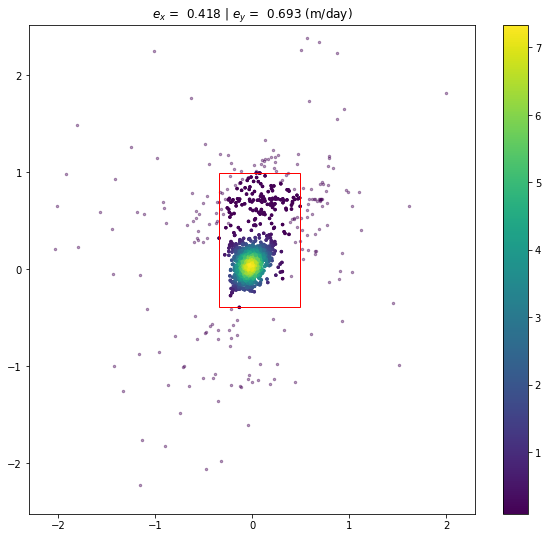

In [36]:
import matplotlib.patches as patches

viridis = cm.get_cmap('viridis', 12)
pt_style = {'s': 6, 'edgecolor': None}

fig, axt = plt.subplots(1, 1, figsize=(10, 9))
vx, vy, z, thres_idx = off_ice_errors_withweight(vxfile=demo.Vx, vyfile=demo.Vy, off_ice_area=in_shp, max_n=10000, plot=True, ax=axt)

idx = thres_idx    # alias
axt.axis('equal')
tmp = axt.scatter(vx[idx], vy[idx], c=z[idx], **pt_style)
# axt.scatter(vx[~idx], vy[~idx], color=viridis(0), alpha=0.4, **pt_style)
# # axt.set_xlim((min(vx[idx]), max(vx[idx])))
# # axt.set_ylim((min(vy[idx]), max(vy[idx])))
axt.set_xlim(-2.3, 2.3)
axt.set_ylim(-2.3, 2.3)

# (left, bottom), width, height
rect = patches.Rectangle((min(vx[thres_idx]), min(vy[thres_idx])), max(vx[thres_idx]) - min(vx[thres_idx]), max(vy[thres_idx]) - min(vy[thres_idx]), 
                         linewidth=1, edgecolor='r', facecolor='none')
axt.add_patch(rect)
axt.set_title('$e_x$ = {:6.3f} | $e_y$ = {:6.3f} (m/day)'.format(0.5 * (max(vx[thres_idx]) - min(vx[thres_idx])), 
                                                                 0.5 * (max(vy[thres_idx]) - min(vy[thres_idx]))))

fig.colorbar(tmp)

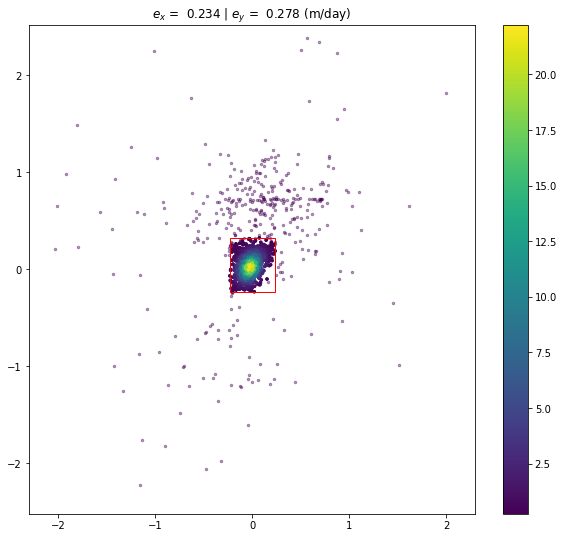

In [37]:
import matplotlib.patches as patches

viridis = cm.get_cmap('viridis', 12)
pt_style = {'s': 6, 'edgecolor': None}

fig, axt = plt.subplots(1, 1, figsize=(10, 9))
vx, vy, z, thres_idx = off_ice_errors_withweight(vxfile=demo.Vx, vyfile=demo.Vy, wfile=demo.Vx.replace('u_', 'pkr_'), off_ice_area=in_shp, max_n=10000, plot=True, ax=axt)

idx = thres_idx    # alias
axt.axis('equal')
tmp = axt.scatter(vx[idx], vy[idx], c=z[idx], **pt_style)
# axt.scatter(vx[~idx], vy[~idx], color=viridis(0), alpha=0.4, **pt_style)
# # axt.set_xlim((min(vx[idx]), max(vx[idx])))
# # axt.set_ylim((min(vy[idx]), max(vy[idx])))
axt.set_xlim(-2.3, 2.3)
axt.set_ylim(-2.3, 2.3)

# (left, bottom), width, height
rect = patches.Rectangle((min(vx[thres_idx]), min(vy[thres_idx])), max(vx[thres_idx]) - min(vx[thres_idx]), max(vy[thres_idx]) - min(vy[thres_idx]), 
                         linewidth=1, edgecolor='r', facecolor='none')
axt.add_patch(rect)
axt.set_title('$e_x$ = {:6.3f} | $e_y$ = {:6.3f} (m/day)'.format(0.5 * (max(vx[thres_idx]) - min(vx[thres_idx])), 
                                                                 0.5 * (max(vy[thres_idx]) - min(vy[thres_idx]))))

fig.colorbar(tmp)

In [38]:
demo.Vx

'/home/jovyan/Projects/PX_comparison/PX/GIV/u_l12_NAOF_200.tif'